# Getting to know neural networks

In [1]:
# Import packages
import numpy as np
import torch
import plotly.graph_objects as go
from nn import *

## Gradient descent

Neural networks look pretty simple, a multi-layer perceptron is just a stack of simple non-linear regressions.  But deep learning is beating everything else on AI problems, and actually getting it to work well is surprisingly difficult.

Things to implement and understand well:
- Data centering - done
- Parameter initialisation - done
- Learning rate tuning*
- Stochastic gradient descent (batch size)*
- Batch normalisation*
- Layer size
- Layer normalisation*
- Network depth
- Regularisation*

*May not apply to Bayesian deep learning?

Should really start with no hidden layer and explain it better.  Do it when you get to multiple layers.

Initialisation is really important.  Need data centered and scaled, positive and negative gradients, and zero intercepts. Actually small initial intercepts seem to help a lot, though there seems to be some disagreement about it.  Seems to help neurons seperate out.  I wonder about manually initialising knots spread evenly across the domain of the data.  And I still wonder about adding neurons with knots at the areas of highest loss.  Also realised the layers add knots by translating earlier ones, but by raising the function up and down and cutting it, so it depends on the earlier function.  It can still be exponential I think.  But also it means they can add knots locally rather than as hyperplanes over the whole domain.  Apart from that they just modify the function over them more efficiently.  I definitely need to play with layers more.

Learning rate is really important, too big and all the neurons get blown out of the domain. Should be smaller for larger batch sizes and numbers of neurons, as the effect is applied over all of them.  Is there a principled way to guess them?  Yes, momentum, RMSProp, and Adam are some basics, and learning rate decay should be applied on top of all of them (https://www.deeplearning.ai/ai-notes/optimization/#II).  Unless there's something better?  (https://www.fast.ai/2018/07/02/adam-weight-decay/)  But I don't wanna spend too much time on this as it doesn't apply to Bayesian DL?  It should be simple to start small and gradually increase while checking how the loss changes and then decrease again.  Surely someone's done that.  Anyway, yeah, no big deal right now.

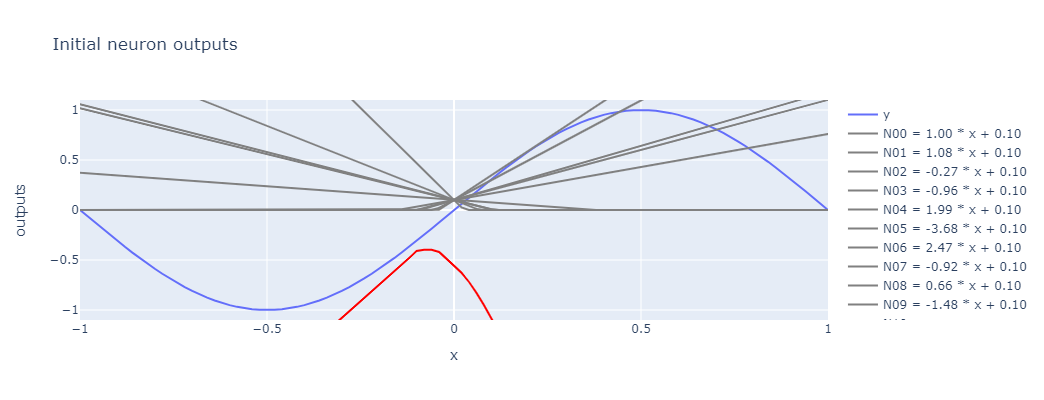

Iteration 0
Iteration 50
Iteration 100
Iteration 150
Reached maximum number of iterations


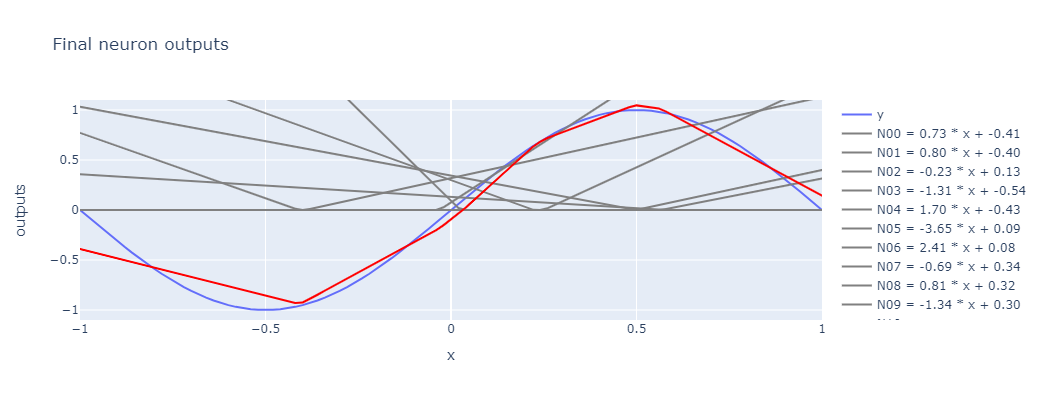

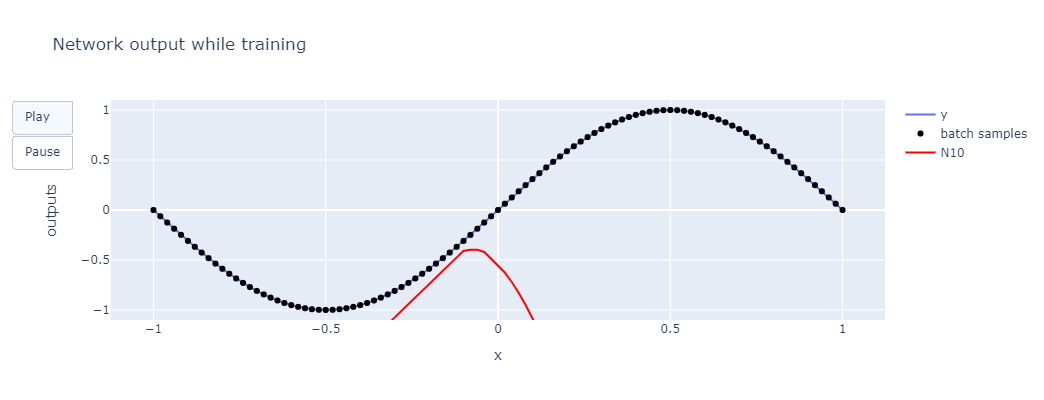

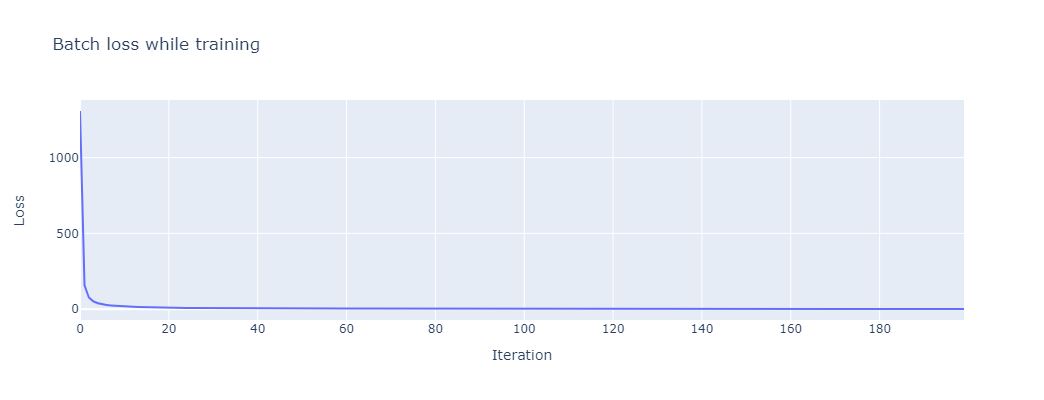

In [2]:
# Make data
r = 1
x = torch.linspace(-r, r, 101).reshape(101, 1)

# Target functions, from easy to hard
# y = torch.maximum(2 * x, torch.zeros_like(x))
# y = x**3
# y = np.exp(x)
y = np.sin(np.pi * x)

# Set number of neurons in hidden layer
n_hidden=10

# Initialise parameters and plot intial neuron outputs
par = init_par(n_hidden, x, y)
        
# Run gradient descent
par = fit_nn(
    par, x, y, n_hidden, batch_p=1, lr=5e-4, max_it=int(2e2), its_per_frm=10
)

## Variational inference

In [6]:
import torch.distributions as td    # PyTorch's probability distributions package
import matplotlib.pyplot as plt     # Matplotlib's Python plotting package
from tqdm.notebook import trange    # progress bars

Assume the target is normally distributed around some mean function of the input, given by a neural network, with some variance.

\begin{equation*}
p(y | x, \theta) := \mathcal{N}(\mu = NN(x, \theta), K(y, y') = \mathcal{I})
\end{equation*}

Put a prior on the parameters of the network

\begin{equation*}
p(\theta) := \mathcal{N}(\mu = 0, \sigma^2 = 100 \mathcal{I})
\end{equation*}

and try to infer their posterior.

In [ ]:
# Make data
r = 1
x = torch.linspace(-r, r, 101).reshape(101, 1)

# Target functions, from easy to hard
# y = torch.maximum(2 * x, torch.zeros_like(x))
# y = x**3
# y = np.exp(x)
y = np.sin(np.pi * x)

# Set number of neurons in hidden layer
n_hidden=10

### Likelihood

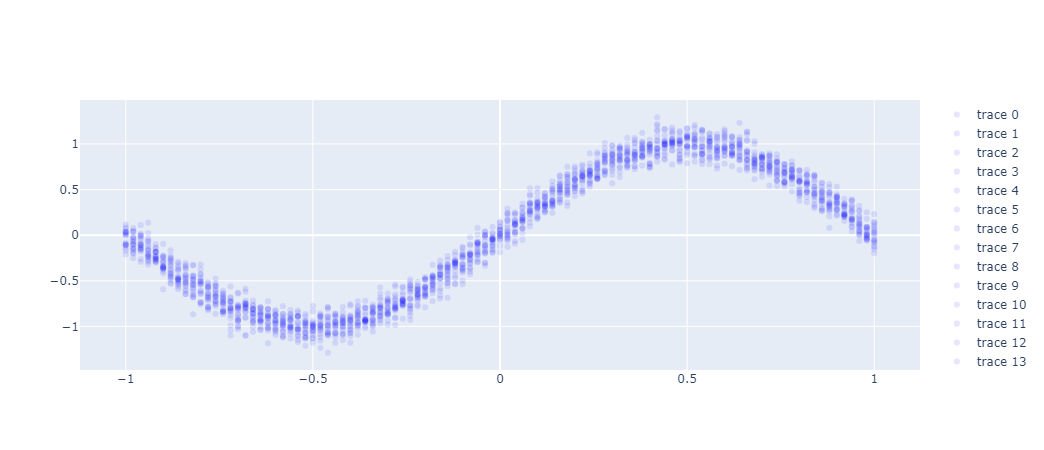

In [113]:
y_dist = td.MultivariateNormal(loc=y[:, 0], covariance_matrix=0.01 * torch.eye(101))
y_samples = y_dist.rsample(sample_shape=torch.Size([50]))
data = []
for s in range(20):
    data = data + [go.Scatter(
        x=x[:, 0], y=y_samples[s, :].numpy(), mode='markers', marker_color='blue', opacity=0.1
    )]
go.Figure(data=data).show()

### Variational distribution

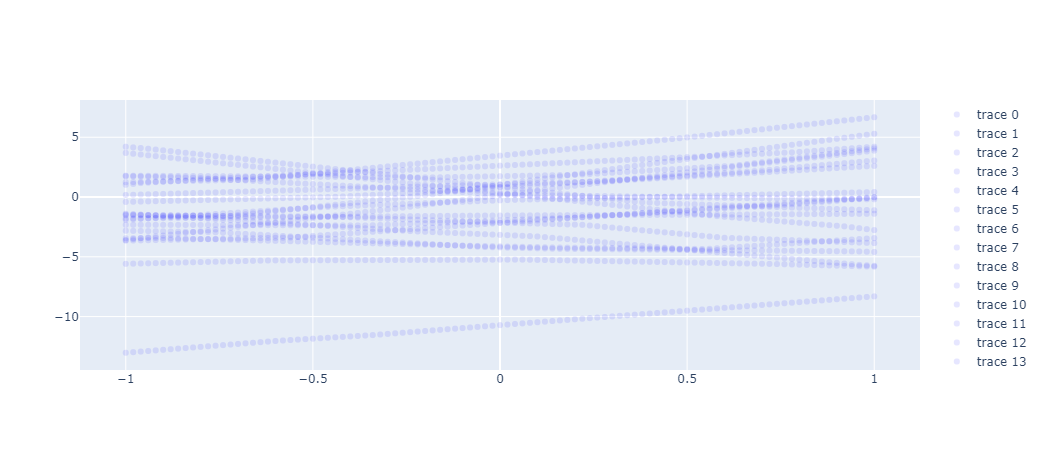

In [114]:
n_par = n_hidden * 3 + 1
q_mean = torch.randn([n_par], requires_grad=True)
q_sd = torch.rand([n_par], requires_grad=True)
q_dist = td.MultivariateNormal(loc=q_mean, covariance_matrix=torch.diag(q_sd))
q_samples = q_dist.rsample(sample_shape=torch.Size([50]))

data = []
for s in range(20):
    W0, b0, W1, b1 = par_split(q_samples[s, :], n_hidden)
    A0 = x @ W0 + b0
    N0 = torch.maximum(A0, torch.zeros_like(A0))
    N1 = N0 @ W1 + b1
    data = data + [go.Scatter(
        x=x[:, 0], y=N1[:, 0].detach(), mode='markers', marker_color='blue', opacity=0.1
    )]

go.Figure(data=data).show()

As variational distribution, we will be simply using a single Gaussian:

\begin{equation*}
q_\phi(\theta) := \mathcal{N}(\theta; \mu_q, \sigma_q^2)\,,
\end{equation*}

where $\phi := (\mu_q,\sigma_q)$ are the variational parameters, which are randomly initialised.

<b>Exercise:</b> In this simple problem, we can directly compute the KL divergence between the target distribution
 (i.e., the mixture of Gaussians) and the variational distribution. As a first exercise, implement the sample-based
 KL divergence approximation:

\begin{equation*}
\mathrm{KL}(q_\phi||p) := \mathbb{E}_{\theta\sim q_\phi}\left[\log\frac{q_\phi(\theta)}{p(\theta)}\right]
\approx \frac{1}{S}\sum_{i=1}^S \log\frac{q_\phi(\theta^{(i)})}{p(\theta^{(i)})}\,,
\end{equation*}

where $\{\theta^{(i)}\}_{i=1}^S\overset{i.i.d.}{\sim} q_\phi$.

In [112]:
def kl_divergence(samples: torch.Tensor,
                  p_distribution: td.Distribution,
                  q_distribution: td.Distribution) -> torch.Tensor:
    """

    :param samples: samples from the variational distribtuion
    :param p_distribution: probability distribution object representing the true posterior
    :param q_distribution: variational distribution object
    :return: an empirical approximation of the KL divergence between the variational distribution and the true posterior
    """
    # pass    # TODO
    return (q_distribution.log_prob(samples) - p_distribution.log_prob(samples)).mean()

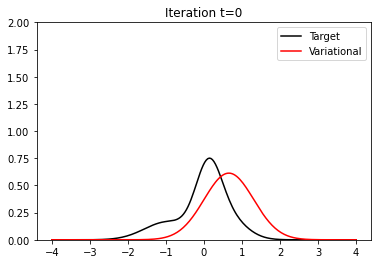

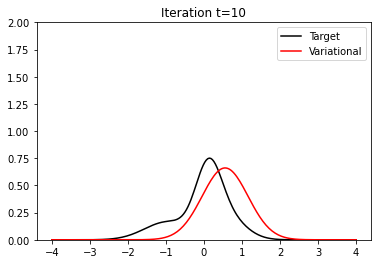

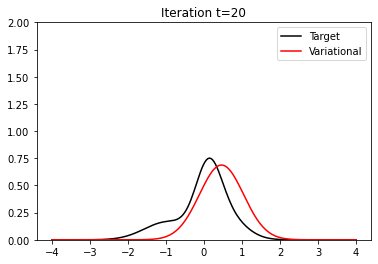

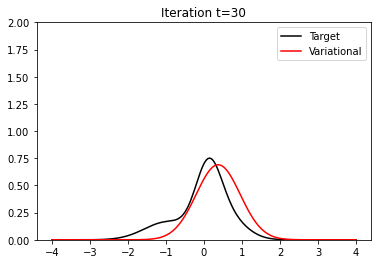

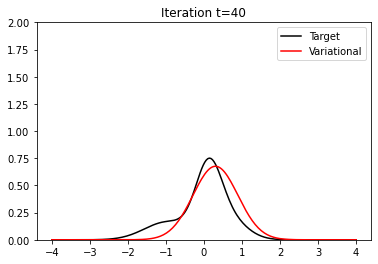

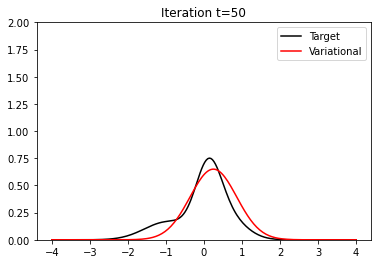

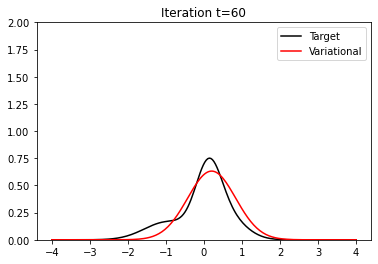

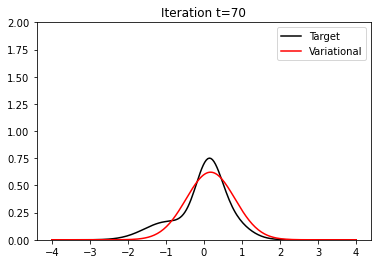

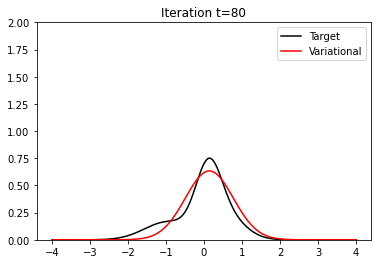

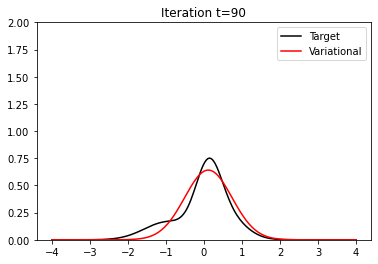

In [11]:
n_iterations = 100   # number of iterations to run gradient descent for
plot_every = 10
opt = torch.optim.Adam([q_mean, q_sd], lr=1e-2) # optimisation algorithm
n_samples = 20     # number of samples of the variational distribution to compute the KL divergence with
losses = torch.zeros(n_iterations)
pbar = trange(n_iterations)

for t in pbar:
    opt.zero_grad()
    q_dist = td.MultivariateNormal(loc=q_mean, covariance_matrix=torch.diag(q_sd))
    
#     The rsample() method applies the reparameterisation trick,
#     so that we can differentiate through the samples
    q_samples = q_dist.rsample([n_samples])

    W0, b0, W1, b1 = par_split(q_samples[s, :], n_hidden)
    A0 = x @ W0 + b0
    N0 = torch.maximum(A0, torch.zeros_like(A0))
    N1 = N0 @ W1 + b1
    y_dist = td.MultivariateNormal(loc=N1[:, 0], covariance_matrix=0.01 * torch.eye(101))
    
    loss = kl_divergence(q_samples, y_dist, q_dist) # KL divergence empirical approximation
    loss.backward()
    opt.step()
    losses[t] = loss.item()
    pbar.set_postfix(loss=loss.item())

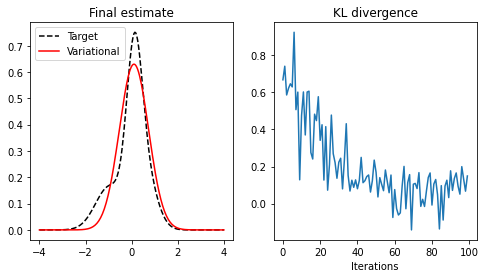

In [12]:
with torch.no_grad():
        plt.figure(figsize=(8,4))
        plt.subplot(121)
        plt.plot(test_x, true_p, 'k--', label='Target')
        plt.plot(test_x, q_dist.log_prob(test_x).exp(), 'r-', label='Variational')
        plt.legend()
        plt.title("Final estimate")

        plt.subplot(122)
        plt.plot(losses)
        plt.title("KL divergence")
        plt.xlabel("Iterations")